In [3]:
###########################################################################     
############################ model training ###############################
###########################################################################


inp = input('Are you compiling on google colab?, y/n: ')
if inp.lower() == "y":
    print("We are using google colab")
    ############## if compile on google colab #################
    !pip install import-ipynb
    import import_ipynb

    !pip install -U -q PyDrive
    from pydrive.auth import GoogleAuth
    from pydrive.drive import GoogleDrive
    from google.colab import auth
    from oauth2client.client import GoogleCredentials

    auth.authenticate_user()
    gauth = GoogleAuth()
    gauth.credentials = GoogleCredentials.get_application_default()
    drive = GoogleDrive(gauth)

    your_module = drive.CreateFile({'id':'1wCNx7SWrCPL78UmmzEF6pAfdniCVJUWS'})
    # https://drive.google.com/open?id=1wCNx7SWrCPL78UmmzEF6pAfdniCVJUWS
    your_module.GetContentFile('data_preprocessing.ipynb')
    import data_preprocessing as dp
    
    data = dp.process_data(1)
    
    
elif inp.lower() == "n":
    print("We are using local machine")
    ########## if compile locally ###############
    import data_preprocessing as dp
    
    data = dp.process_data(0)
else:
    print("Please reply y/n")
    
    


from fastai.vision import *
from fastai.metrics import error_rate
from sklearn.metrics import confusion_matrix

Are you compiling on google colab?, y/n: y
We are using google colab
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
     |████████████████████████████████| 993kB 3.5MB/s 
importing Jupyter notebook from data_preprocessing.ipynb
Importing data from google drive
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive

Created ./original_data/

Created ./processed_data/

Created ./processed_data/test

Created ./processed_data/t

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 73030055.64it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


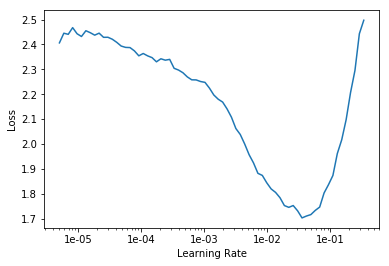

In [4]:
learn = cnn_learner(data,models.resnet34,metrics=error_rate)

learn.model

learn.lr_find(start_lr=1e-6,end_lr=1e1)
learn.recorder.plot()

In [7]:
learn.fit_one_cycle(20,max_lr=3.6e-03)

epoch,train_loss,valid_loss,error_rate,time
0,0.119016,0.254348,0.069307,00:39
1,0.157239,0.270952,0.077228,00:39
2,0.153101,0.284632,0.081188,00:40
3,0.212964,0.348821,0.108911,00:39
4,0.318640,0.408350,0.130693,00:40
5,0.351642,0.388281,0.134653,00:39
6,0.300398,0.368936,0.116832,00:40
7,0.362827,0.400334,0.124752,00:41
8,0.315690,0.318456,0.116832,00:40
9,0.258419,0.339624,0.104950,00:40


In [0]:
preds = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
max_idxs = np.asarray(np.argmax(preds[0],axis=1))

In [0]:
yhat = []
for max_idx in max_idxs:
    yhat.append(data.classes[max_idx])

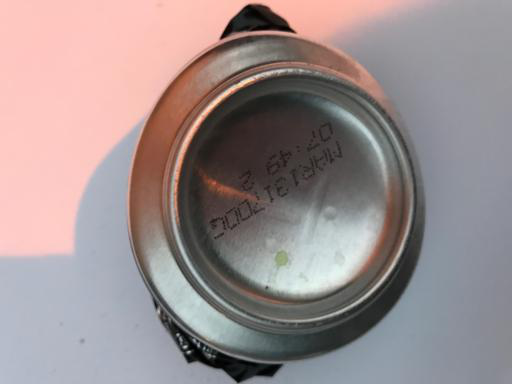

In [11]:
learn.data.test_ds[0][0]

In [0]:
y = []

## convert POSIX paths to string first
for label_path in data.test_ds.items:
    y.append(str(label_path))
    
## then extract waste type from file path
pattern = re.compile("([a-z]+)[0-9]+")
for i in range(len(y)):
    y[i] = pattern.search(y[i]).group(1)

In [17]:
## predicted values
print(yhat[300:305])
## actual values
print(y[300:305])

['paper', 'paper', 'paper', 'paper', 'paper']
['paper', 'paper', 'paper', 'paper', 'paper']


In [14]:

cm = confusion_matrix(y,yhat)
print(cm)

[[ 79   0   0   1   0   0]
 [  0  93   4   0   3   0]
 [  0   1  80   0   0   1]
 [  1   0   0 115   0   2]
 [  1   4   1   1  88   1]
 [  0   0   1   0   1  25]]


In [0]:
correct = 0

for r in range(len(cm)):
    for c in range(len(cm)):
        if (r==c):
            correct += cm[r,c]

In [16]:
accuracy = correct/sum(sum(cm))
accuracy

0.9542743538767395

In [18]:
############## error analysis ###############
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.most_confused(min_val=2)

[('metal', 'glass', 5),
 ('paper', 'trash', 5),
 ('plastic', 'glass', 4),
 ('glass', 'plastic', 3),
 ('metal', 'plastic', 3),
 ('plastic', 'metal', 3),
 ('cardboard', 'paper', 2),
 ('paper', 'cardboard', 2)]

The model confused glass for metal and trash for paper 5 times.